# Tutorial: Preprocessing Different File Types

- **Level**: Beginner
- **Time to complete**: 15 minutes
- **Goal**: After completing this tutorial, you'll have learned how to build an indexing pipeline that will preprocess files based on their file type, using the `FileTypeRouter`.

> This tutorial uses Haystack 2.0. To learn more, read the [Haystack 2.0 announcement](https://haystack.deepset.ai/blog/haystack-2-release) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/docs/intro).

> 💡 (Optional): After creating the indexing pipeline in this tutorial, there is an optional section that shows you how to create a RAG pipeline on top of the document store you just created. You must have a [Hugging Face API Key](https://huggingface.co/settings/tokens) for this section

## Components Used

- [`FileTypeRouter`](https://docs.haystack.deepset.ai/v2.0/docs/filetyperouter): This component will help you route files based on their corresponding MIME type to different components
- [`MarkdownToDocument`](https://docs.haystack.deepset.ai/v2.0/docs/markdowntodocument): This component will help you convert markdown files into Haystack Documents
- [`PyPDFToDocument`](https://docs.haystack.deepset.ai/v2.0/docs/pypdftodocument): This component will help you convert pdf files into Haystack Documents
- [`TextFileToDocument`](https://docs.haystack.deepset.ai/v2.0/docs/textfiletodocument): This component will help you convert text files into Haystack Documents
- [`DocumentJoiner`](https://docs.haystack.deepset.ai/v2.0/docs/documentjoiner): This component will help you to join Documents coming from different branches of a pipeline
- [`DocumentCleaner`](https://docs.haystack.deepset.ai/v2.0/docs/documentcleaner) (optional): This component will help you to make Documents more readable by removing extra whitespaces etc.
- [`DocumentSplitter`](https://docs.haystack.deepset.ai/v2.0/docs/documentsplitter): This component will help you to split your Document into chunks
- [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformersdocumentembedder): This component will help you create embeddings for Documents.
- [`DocumentWriter`](https://docs.haystack.deepset.ai/v2.0/docs/documentwriter): This component will help you write Documents into the DocumentStore

## Overview

In this tutorial, you'll build an indexing pipeline that preprocesses different types of files (markdown, txt and pdf). Each file will have its own `FileConverter`. The rest of the indexing pipeline is fairly standard - split the documents into chunks, trim whitespace, create embeddings and write them to a Document Store.

Optionally, you can keep going to see how to use these documents in a query pipeline as well.

## Preparing the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/v2.0/docs/enabling-gpu-acceleration)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v2.0/docs/logging)

## Installing dependencies


In [1]:
%%bash
pip install haystack-ai
pip install "sentence-transformers>=2.2.0"
pip install markdown-it-py mdit_plain
pip install pypdf

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 6.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 9.0 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 2.1 MB/s eta 0:00:00a 0:00:01


### Enabling Telemetry

Knowing you’re using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/v2.0/docs/enabling-telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(30)

## Download All Files

Files that you will use in this tutorial are stored in a [GDrive folder](https://drive.google.com/drive/folders/1n9yqq5Gl_HWfND5bTlrCwAOycMDt5EMj). Either download files from the GDrive folder or run the code below. If you're running this tutorial on colab, you'll find the downloaded files under "/recipe_files" folder in "files" tab on the left.

Just like most real life data, these files are a mishmash of different types.

In [ ]:
%%bash

pip install gdown
gdown https://drive.google.com/drive/folders/1n9yqq5Gl_HWfND5bTlrCwAOycMDt5EMj -O recipe_files --folder

## Create a Pipeline to Index Documents

Next, you'll create a pipeline to index documents. To keep things uncomplicated, you'll use an `InMemoryDocumentStore` but this approach would also work with any other flavor of `DocumentStore`.

You'll need a different file converter class for each file type in our data sources: `.pdf`, `.txt`, and `.md` in this case. Our `FileTypeRouter` connects each file type to the proper converter.

Once all our files have been converted to Haystack Documents, we can use the `DocumentJoiner` component to make these a single list of documents that can be fed through the rest of the indexing pipeline all together.

In [5]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf", "text/markdown"])
text_file_converter = TextFileToDocument()
markdown_converter = MarkdownToDocument()
pdf_converter = PyPDFToDocument()
document_joiner = DocumentJoiner()

/Users/bilgeyucel/Desktop/deepset/haystack-tutorials/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


From there, the steps to this indexing pipeline are a bit more standard. The `DocumentCleaner` removes whitespace. Then this `DocumentSplitter` breaks them into chunks of 150 words, with a bit of overlap to avoid missing context.

In [6]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50)

Now you'll add a `SentenceTransformersDocumentEmbedder` to create embeddings from the documents. As the last step in this pipeline, the `DocumentWriter` will write them to the `InMemoryDocumentStore`.


In [7]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

After creating all the components, add them to the indexing pipeline.

In [8]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=markdown_converter, name="markdown_converter")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

Next, connect them 👇

In [14]:
preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("file_type_router.text/markdown", "markdown_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
preprocessing_pipeline.connect("markdown_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

Let's test this pipeline with a few recipes I've written. Are you getting hungry yet?

In [21]:
from pathlib import Path

preprocessing_pipeline.run({"file_type_router": {"sources": list(Path("recipe_files").glob("**/*"))}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


{'document_writer': {'documents_written': 1}}

🎉 If you only wanted to learn how to preprocess documents, you can stop here! If you want to see an example of using those documents in a RAG pipeline, read on.  

## (Optional) Build a pipeline to query documents

Now, let's build a RAG pipeline that answers queries based ont he documents you just created in the section above. For this step, we will be using the [`HuggingFaceTGIGenerator`](https://docs.haystack.deepset.ai/v2.0/docs/huggingfacetgigenerator) so must have a [Hugging Face API Key](https://huggingface.co/settings/tokens) for this section. We will be using the `mistralai/Mistral-7B-Instruct-v0.1` model.

In [10]:
import os
from getpass import getpass

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")

Enter Hugging Face token: ··········


In this step you'll build a query pipeline to answer questions about the documents.

This pipeline takes the prompt, searches the document store for relevant documents, and passes those documents along to the LLM to formulate an answer.

> ⚠️ Notice how we used `sentence-transformers/all-MiniLM-L6-v2` to create embeddings for our documents before. This is why we will be using the same model to embed incoming questions.

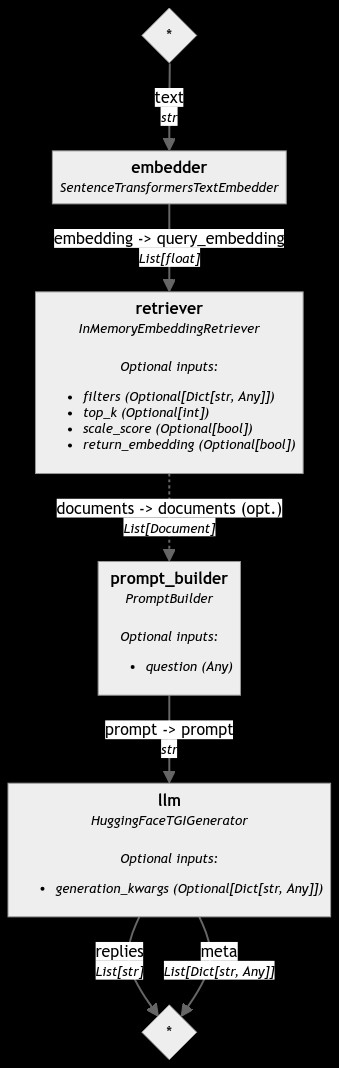

In [13]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""
pipe = Pipeline()
pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.1"))

pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")

Try it out yourself by running the code below. If all has gone well, you should have a complete shopping list from all the recipe sources. 🧂🥥🧄

In [ ]:
question = (
    "What ingredients would I need to make vegan keto eggplant lasagna, vegan persimmon flan, and vegan hemp cheese?"
)

pipe.run(
    {
        "embedder": {"text": question},
        "prompt_builder": {"question": question},
        "llm": {"generation_kwargs": {"max_new_tokens": 350}},
    }
)

```python
{'llm': {'replies': ['\n\nFor vegan keto eggplant lasagna, you would need:\n\n* 2 large eggplants\n* a lot of salt (Hella salt)\n* 1/2 cup store-bought vegan mozzarella (for topping)\n* Pesto: 4 oz basil, 1/4 cup almonds, 1/4 cup nutritional yeast, 1/4 cup olive oil, 1 recipe vegan pesto, 1 recipe spinach tofu ricotta, 1 tsp garlic powder, juice of half a lemon, salt to taste\n* Macadamia nut cheese: 1 cup macadamia nuts, 10 oz spinach, juice of 1 lemon, garlic powder to taste, salt to taste\n\nFor vegan persimmon flan, you would need:\n\n* ½ cup persimmon pulp, strained\n* 1 tbsp cornstarch\n* ½ tsp agar agar\n* 1 tbsp agave nectar, or to taste\n* 2 tbsp granulated sugar\n* ¼ cup coconut creme\n* ½ cup almond milk\n* ½ tsp vanilla\n\nFor vegan hemp cheese, you would need:\n\n* ½ cup sunflower seeds\n* ½ cup hemp hearts\n* 1.5 teaspoons miso paste\n* 1 tsp nutritional yeast\n* ¼ cup rejuvelac*\n* 1/4th teaspoon salt, or to taste\n\nNote:'],
  'meta': [{'model': 'mistralai/Mistral-7B-Instruct-v0.1',
    'index': 0,
    'finish_reason': 'length',
    'usage': {'completion_tokens': 350,
     'prompt_tokens': 3454,
     'total_tokens': 3804}}]}}
```

## What's next

Congratulations on building an indexing pipeline that can preprocess different file types. Go forth and ingest all the messy real-world data into your workflows. 💥

If you liked this tutorial, you may also enjoy:
- [Serializing Haystack Pipelines](https://haystack.deepset.ai/tutorials/29_serializing_pipelines)
-  [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates?utm_campaign=developer-relations&utm_source=tutorial&utm_medium=filte_type_routing). Thanks for reading!